In [37]:
# ============================================================
# 1. Instalación de dependencias (solo necesario en Colab)
# ============================================================
!pip install -q kagglehub

# ============================================================
# 2. Imports
# ============================================================
import os
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

from sklearn.metrics import classification_report, confusion_matrix
import kagglehub

# ============================================================
# 3. Configuración general
# ============================================================
SEED = 42
IMG_SIZE = (48, 48)
BATCH_SIZE = 64
LEARNING_RATE = 1e-3

tf.random.set_seed(SEED)
np.random.seed(SEED)

# ============================================================
# 4. Descarga del dataset FER desde KaggleHub
# ============================================================
path = kagglehub.dataset_download("ananthu017/emotion-detection-fer")

print("Ruta base del dataset:", path)
print("Contenido de la carpeta raíz:", os.listdir(path))

train_dir = os.path.join(path, "train")
test_dir  = os.path.join(path, "test")

print("Train dir:", train_dir)
print("Test dir:", test_dir)


Using Colab cache for faster access to the 'emotion-detection-fer' dataset.
Ruta base del dataset: /kaggle/input/emotion-detection-fer
Contenido de la carpeta raíz: ['test', 'train']
Train dir: /kaggle/input/emotion-detection-fer/train
Test dir: /kaggle/input/emotion-detection-fer/test


In [51]:
import os
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

IMG_SIZE = (48, 48)
COLOR_MODE = 'grayscale'
train_dir = '/root/.cache/kagglehub/datasets/ananthu017/emotion-detection-fer/versions/1/train'

target_per_class = {
    'angry':      6000,
    'disgusted':  8000,   # Sobremuestreo agresivo
    'fearful':    6000,
    'happy':      6000,
    'neutral':    6000,
    'sad':        6000,
    'surprised':  6000,
}

# === CAMBIOS EN PARÁMETROS ===
# Más conservadores para no destruir micro-expresiones en 48x48
datagen = ImageDataGenerator(
    rotation_range=15,      # Bajamos de 45 a 15 (suficiente para variar cuello)
    zoom_range=0.15,        # Bajamos de 0.3 a 0.15 (no perder contexto)
    width_shift_range=0.1,  # 10% es ~5 px, suficiente.
    height_shift_range=0.1,
    shear_range=0.05,       # Casi nada de shear, deforma mucho las caras
    brightness_range=[0.7, 1.3], # Un poco menos agresivo que 0.5
    horizontal_flip=True,
    fill_mode='nearest'
)

for class_name, target_count in target_per_class.items():
    class_path = os.path.join(train_dir, class_name)
    # Listar solo imágenes válidas
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    current_count = len(images)

    print(f"\nClase: {class_name} | actuales: {current_count} | objetivo: {target_count}")

    if current_count >= target_count:
        print(" -> Ya tiene suficientes imágenes. Saltando.")
        continue

    # === LÓGICA CORREGIDA ===
    # 1. Calculamos cuántas faltan
    needed = target_count - current_count

    # 2. Calculamos cuántas vueltas (augments) dar por cada imagen original
    # El 'ceil' asegura que lleguemos al objetivo
    aug_per_image = math.ceil(needed / current_count)

    print(f" -> Faltan {needed}. Generando aprox {aug_per_image} por imagen original...")

    generated_count = 0

    for img_name in images:
        # Si ya llegamos al tope en medio del bucle, paramos
        if current_count + generated_count >= target_count:
            break

        try:
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path, color_mode=COLOR_MODE, target_size=IMG_SIZE)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            # Generamos las N copias para ESTA imagen
            i = 0
            for batch in datagen.flow(x, batch_size=1):
                aug_img = array_to_img(batch[0].astype('uint8'))

                # Nombre único para evitar sobrescribir
                save_name = f"aug_{generated_count}_{img_name}"
                save_path = os.path.join(class_path, save_name)

                aug_img.save(save_path)

                generated_count += 1
                i += 1

                # Condición de salida para esta imagen específica
                # O si ya llenamos el cupo global
                if i >= aug_per_image or current_count + generated_count >= target_count:
                    break
        except Exception as e:
            print(f"Error procesando {img_name}: {e}")

    print(f" -> Generadas: {generated_count} | Total final: {current_count + generated_count}")


Clase: angry | actuales: 3995 | objetivo: 6000
 -> Faltan 2005. Generando aprox 1 por imagen original...
 -> Generadas: 2005 | Total final: 6000

Clase: disgusted | actuales: 4000 | objetivo: 8000
 -> Faltan 4000. Generando aprox 1 por imagen original...
 -> Generadas: 4000 | Total final: 8000

Clase: fearful | actuales: 4097 | objetivo: 6000
 -> Faltan 1903. Generando aprox 1 por imagen original...
 -> Generadas: 1903 | Total final: 6000

Clase: happy | actuales: 7215 | objetivo: 6000
 -> Ya tiene suficientes imágenes. Saltando.

Clase: neutral | actuales: 4965 | objetivo: 6000
 -> Faltan 1035. Generando aprox 1 por imagen original...
 -> Generadas: 1035 | Total final: 6000

Clase: sad | actuales: 4830 | objetivo: 6000
 -> Faltan 1170. Generando aprox 1 por imagen original...
 -> Generadas: 1170 | Total final: 6000

Clase: surprised | actuales: 4000 | objetivo: 6000
 -> Faltan 2000. Generando aprox 1 por imagen original...
 -> Generadas: 2000 | Total final: 6000


In [52]:
# ============================================================
# 5. Carga de datasets
# ============================================================
# NOTA: Al haber aumentado datos dentro de la carpeta de train,
# el validation_split tendrá "fuga de datos" (imágenes parecidas en train y val).
# Por lo tanto, tu métrica REAL de confianza será el resultado de test_ds, no val_ds.

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,  # Este directorio NO tiene imágenes generadas, es puro.
    image_size=IMG_SIZE,
    color_mode="grayscale",
    shuffle=False,
    batch_size=BATCH_SIZE,
)

class_names = train_ds.class_names
print("Clases:", class_names)

# ============================================================
# 6. Preparación
# ============================================================

AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, cache=False):
    if shuffle:
        ds = ds.shuffle(1000) # Buffer más pequeño para ahorrar RAM si hay muchas imgs
    if cache:
        ds = ds.cache()
    ds = ds.prefetch(AUTOTUNE)
    return ds

# === CAMBIO IMPORTANTE: Class Weights ===
# Como ya hicimos Oversampling Físico (tienes 8000 disgusted vs 6000 happy),
# NO necesitamos forzar los pesos manualmente a 3.0.
# De hecho, podríamos usar pesos 1.0 para todos, o dejar que Sklearn los calcule suavemente.

from sklearn.utils import class_weight
import numpy as np

# Obtenemos etiquetas para calcular el peso matemático exacto (opcional, pero recomendado)
all_labels = []
print("Contando etiquetas para verificar balance...")
for _, labels in train_ds:
    all_labels.extend(labels.numpy())

# Calculamos pesos automáticos "suaves" para equilibrar las diferencias pequeñas (6000 vs 8000)
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)

# Convertimos a diccionario para Keras
class_weight_dict = {i: w for i, w in enumerate(class_weights_array)}

print("\nNuevos pesos automáticos (compensan que disgusted tenga 8000):")
# Verás que 'disgusted' tendrá un peso MENOR que los demás (ej. 0.8) porque abunda.
# ESTO ES CORRECTO. Ya se tiene la cantidad, no necesitamos el peso.
for cls_id, w in class_weight_dict.items():
    print(f"  {class_names[cls_id]}: {w:.3f}")

# Preparar datasets
train_ds_p = prepare(train_ds, shuffle=True,  cache=False)
val_ds_p   = prepare(val_ds,   shuffle=False, cache=True)
test_ds_p  = prepare(test_ds,  shuffle=False, cache=True)


Found 45212 files belonging to 7 classes.
Using 36170 files for training.
Found 45212 files belonging to 7 classes.
Using 9042 files for validation.
Found 7178 files belonging to 7 classes.
Clases: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Contando etiquetas para verificar balance...

Nuevos pesos automáticos (compensan que disgusted tenga 8000):
  angry: 1.082
  disgusted: 0.808
  fearful: 1.078
  happy: 0.900
  neutral: 1.072
  sad: 1.073
  surprised: 1.070


In [53]:
import tensorflow as tf

def focal_loss_fixed(gamma=2.0, alpha=0.25):
    def loss_fn(y_true, y_pred):
        # Aseguramos que y_true sea un vector plano (batch,)
        # Esto evita errores si el dataset entrega (batch, 1)
        y_true = tf.reshape(y_true, [-1])
        y_true = tf.cast(y_true, tf.int32)

        y_pred = tf.convert_to_tensor(y_pred)

        # one-hot manual
        num_classes = tf.shape(y_pred)[-1]
        y_true_oh = tf.one_hot(y_true, num_classes)

        # evitar log(0)
        epsilon = 1e-7
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        # focal loss calculation
        ce = -y_true_oh * tf.math.log(y_pred)
        weights = alpha * tf.pow(1. - y_pred, gamma)

        # Sumamos sobre las clases (axis=1) y promediamos sobre el batch
        loss = tf.reduce_sum(weights * ce, axis=1)
        return tf.reduce_mean(loss)

    return loss_fn



In [54]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers

def build_model_final(img_size, num_classes):
    """CNN profunda regularizada para FER, ajustada para dataset pre-aumentado."""

    # 1. Definimos la entrada
    inputs = keras.Input(shape=img_size + (1,))

    # 2. NORMALIZACIÓN PRIMERO (Crítico para que el ruido funcione)
    x = layers.Rescaling(1./255)(inputs)

    # 3. Data Augmentation "Suave" (On-the-fly)
    # Como ya aumentamos físicamente, aquí somos conservadores.
    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),      # ~18 grados max. Suficiente.
        layers.RandomZoom(0.05),          # Zoom leve
        layers.RandomTranslation(0.05, 0.05),
        layers.RandomContrast(0.1),
        layers.GaussianNoise(0.05),       # Ahora sí funciona porque x va de 0 a 1
    ])
    x = data_augmentation(x)

    l2_reg = 1e-4

    # Bloque 1
    x = layers.Conv2D(64, 3, padding="same", use_bias=False, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(64, 3, padding="same", use_bias=False, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.SpatialDropout2D(0.2)(x) # SpatialDropout es genial aquí
    x = layers.MaxPooling2D()(x)

    # Bloque 2
    x = layers.Conv2D(128, 3, padding="same", use_bias=False, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128, 3, padding="same", use_bias=False, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.SpatialDropout2D(0.3)(x)
    x = layers.MaxPooling2D()(x)

    # Bloque 3
    x = layers.Conv2D(256, 3, padding="same", use_bias=False, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(256, 3, padding="same", use_bias=False, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.SpatialDropout2D(0.3)(x)
    x = layers.MaxPooling2D()(x)

    # Bloque 4
    x = layers.Conv2D(512, 3, padding="same", use_bias=False, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(512, 3, padding="same", use_bias=False, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.SpatialDropout2D(0.4)(x)
    x = layers.MaxPooling2D()(x)

    # Clasificación
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)

    # Compilamos DENTRO de la función usando tu Focal Loss externa
    # Asegúrate de que 'focal_loss_fixed' esté definida antes de llamar a esta función
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss=focal_loss_fixed(gamma=2.0, alpha=0.25),
        metrics=["accuracy"],
    )

    return model

In [55]:
# 1. Construir
model = build_model_final(img_size=IMG_SIZE, num_classes=7)

# 2. Callbacks (Igual que antes)
checkpoint_path = "best_model_fer_final.keras"
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1),
    keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor="val_accuracy", save_best_only=True, verbose=1)
]

# 3. Entrenar
print("Iniciando entrenamiento final...")
history = model.fit(
    train_ds_p,
    validation_data=val_ds_p,
    epochs=50,
    callbacks=callbacks_list,
    class_weight=class_weight_dict  # ¡Importante!
)

# 4. Evaluación CRÍTICA (Test set puro)
print("\nEvaluando en Test Set...")
model.evaluate(test_ds_p)

Iniciando entrenamiento final...
Epoch 1/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.1640 - loss: 0.7654
Epoch 1: val_accuracy improved from -inf to 0.18292, saving model to best_model_fer_final.keras
566/566 ━━━━━━━━━━━━━━━━━━━━ 57s 79ms/step - accuracy: 0.1640 - loss: 0.7652 - val_accuracy: 0.1829 - val_loss: 0.5408 - learning_rate: 1.0000e-04
Epoch 2/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.1853 - loss: 0.5563
Epoch 2: val_accuracy improved from 0.18292 to 0.23004, saving model to best_model_fer_final.keras
566/566 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.1853 - loss: 0.5563 - val_accuracy: 0.2300 - val_loss: 0.5339 - learning_rate: 1.0000e-04
Epoch 3/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.1897 - loss: 0.5377
Epoch 3: val_accuracy improved from 0.23004 to 0.23170, saving model to best_model_fer_final.keras
566/566 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.1897 - loss: 0.5377 - val_accuracy: 0.2317 - val_loss: 0.5235

[0.20358657836914062, 0.5548899173736572]

In [45]:
 import tensorflow as tf

# 1. Limpiar sesión (opcional pero recomendable)
tf.keras.backend.clear_session()

# 2. Crear un modelo NUEVO desde cero
model = build_model_final(IMG_SIZE, num_classes, learning_rate=1e-3)

# (opcional) ver que realmente es nuevo
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 48, 48, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_1             │ (None, 24, 24, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,823,111 (18.40 MB)

 Trainable params: 4,819,271 (18.38 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [46]:
# ============================================================
# 8. Callbacks y entrenamiento
# ============================================================

early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-5,
    verbose=1,
)

history = model.fit(
    train_ds_p,
    validation_data=val_ds_p,
    epochs=50,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weight,  # aquí puedes poner el boost para disgusted
)


Epoch 1/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - accuracy: 0.1655 - loss: 2.9757 - val_accuracy: 0.2254 - val_loss: 2.1410 - learning_rate: 0.0010
Epoch 2/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 36s 79ms/step - accuracy: 0.1822 - loss: 2.4799 - val_accuracy: 0.1764 - val_loss: 2.1317 - learning_rate: 0.0010
Epoch 3/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 36s 78ms/step - accuracy: 0.1869 - loss: 2.4439 - val_accuracy: 0.1604 - val_loss: 2.0925 - learning_rate: 0.0010
Epoch 4/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 36s 78ms/step - accuracy: 0.1761 - loss: 2.4001 - val_accuracy: 0.1381 - val_loss: 2.3854 - learning_rate: 0.0010
Epoch 5/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 36s 78ms/step - accuracy: 0.1914 - loss: 2.3534 - val_accuracy: 0.1718 - val_loss: 2.0488 - learning_rate: 0.0010
Epoch 6/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 36s 78ms/step - accuracy: 0.2169 - loss: 2.2944 - val_accuracy: 0.2677 - val_loss: 1.9812 - learning_rate: 0.0010
Epoch 7/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 36s 78ms/step - accuracy: 0.2353 - l

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━

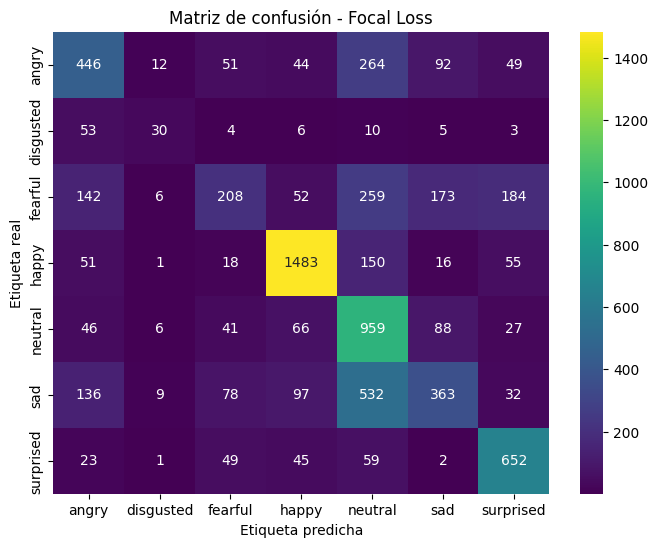

In [47]:
# Predicción
y_true = []
y_pred = []

for images, labels in test_ds_p:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

# Reporte
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print(classification_report(y_true, y_pred, target_names=class_names))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de confusión - Focal Loss")
plt.xlabel("Etiqueta predicha")
plt.ylabel("Etiqueta real")
plt.show()


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5065 - loss: 1.3728
Test loss: 1.2502, test acc: 0.5769


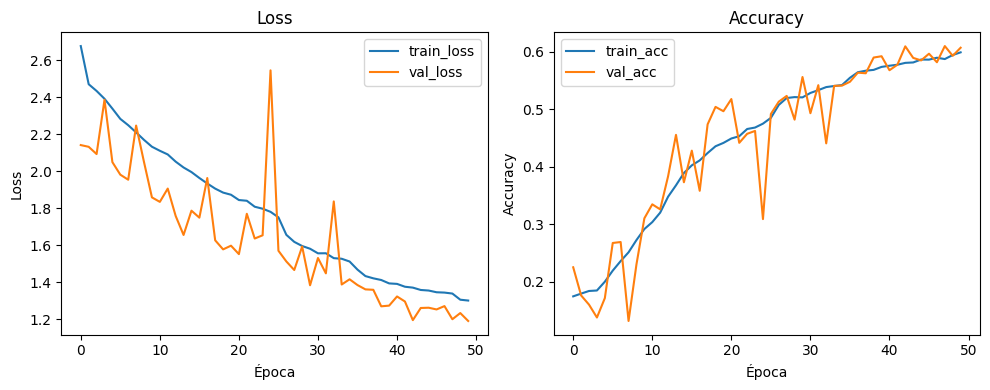

In [48]:
# ============================================================
# 9. Evaluación en test y curvas de entrenamiento
# ============================================================

test_loss, test_acc = model.evaluate(test_ds_p)
print(f"Test loss: {test_loss:.4f}, test acc: {test_acc:.4f}")

hist = history.history

plt.figure(figsize=(10, 4))

# Curva de pérdida
plt.subplot(1, 2, 1)
plt.plot(hist["loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")

# Curva de accuracy
plt.subplot(1, 2, 2)
plt.plot(hist["accuracy"], label="train_acc")
plt.plot(hist["val_accuracy"], label="val_acc")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")

plt.tight_layout()
plt.show()


Classification report:

              precision    recall  f1-score   support

       angry       0.47      0.55      0.50       958
   disgusted       0.52      0.12      0.19       111
     fearful       0.41      0.38      0.39      1024
       happy       0.82      0.82      0.82      1774
     neutral       0.52      0.63      0.57      1233
         sad       0.49      0.41      0.45      1247
   surprised       0.74      0.64      0.68       831

    accuracy                           0.59      7178
   macro avg       0.56      0.51      0.52      7178
weighted avg       0.59      0.59      0.58      7178



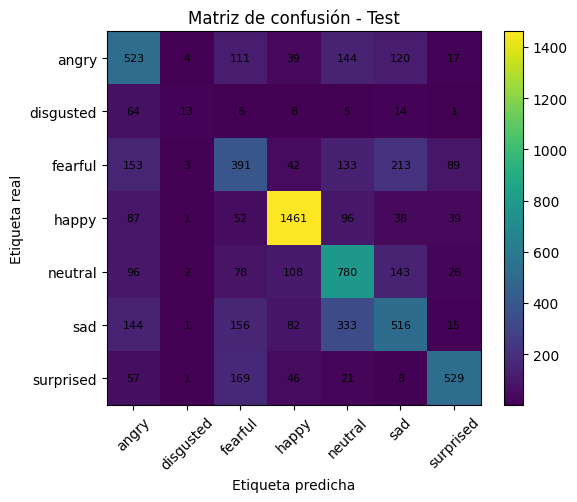

In [ ]:
# ============================================================
# 10. Métricas en test: classification_report + matriz de confusión
# ============================================================

y_true = []
y_pred = []

for images, labels in test_ds_p:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Classification report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation="nearest")
plt.title("Matriz de confusión - Test")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Anotar los valores dentro de cada celda
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, cm[i, j],
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=8
        )

plt.ylabel("Etiqueta real")
plt.xlabel("Etiqueta predicha")
plt.tight_layout()
plt.show()


In [ ]:
# ============================================================
# 11. Distribución de clases en train / val / test
# ============================================================

def contar_labels(ds):
    c = Counter()
    for _, labels in ds:
        c.update(labels.numpy().tolist())
    return c

train_counts = contar_labels(train_ds)
val_counts   = contar_labels(val_ds)
test_counts  = contar_labels(test_ds)

print("Clases:", class_names)

print("\nDistribución en TRAIN:")
for idx, name in enumerate(class_names):
    print(f"{name:10s}: {train_counts[idx]}")

print("\nDistribución en VAL:")
for idx, name in enumerate(class_names):
    print(f"{name:10s}: {val_counts[idx]}")

print("\nDistribución en TEST:")
for idx, name in enumerate(class_names):
    print(f"{name:10s}: {test_counts[idx]}")


Clases: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

Distribución en TRAIN:
angry     : 3218
disgusted : 363
fearful   : 3285
happy     : 5813
neutral   : 3965
sad       : 3834
surprised : 2490

Distribución en VAL:
angry     : 777
disgusted : 73
fearful   : 812
happy     : 1402
neutral   : 1000
sad       : 996
surprised : 681

Distribución en TEST:
angry     : 958
disgusted : 111
fearful   : 1024
happy     : 1774
neutral   : 1233
sad       : 1247
surprised : 831


In [ ]:
import os

os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)

# 1) Guardar el modelo entrenado
model_path = "models/baseline_cnn_48x48_gray.keras"
model.save(model_path)
print(f"✅ Model saved to: {model_path}")

# 2) Guardar history (loss/acc) como .npz
import numpy as np

hist = history.history
np.savez("results/baseline_history_48x48.npz", **hist)
print("✅ Training history saved to: results/baseline_history_48x48.npz")

# 3) Guardar matriz de confusión como imagen
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix - Baseline CNN 48x48")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, cm[i, j],
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=8,
        )

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.savefig("results/confusion_matrix_baseline_48x48.png", dpi=150)
plt.close()

print("✅ Confusion matrix saved to: results/confusion_matrix_baseline_48x48.png")


✅ Model saved to: models/baseline_cnn_48x48_gray.keras
✅ Training history saved to: results/baseline_history_48x48.npz
✅ Confusion matrix saved to: results/confusion_matrix_baseline_48x48.png


## Experiment 1 – Baseline CNN (48×48 grayscale, from scratch)

**Setup:**
- Input: 48×48 grayscale facial images
- Model: Custom CNN (3 conv blocks, GlobalAveragePooling, Dense(128), Dropout)
- Loss: SparseCategoricalCrossentropy
- Optimizer: Adam (learning rate = 1e-3)
- Data augmentation: flips, small rotations, zoom, translations
- Class imbalance: class_weight computed from training label distribution
- Callbacks: EarlyStopping (patience=10), ReduceLROnPlateau (patience=5)

**Results (test set):**
- Test accuracy ≈ 0.58
- Macro F1-score ≈ 0.54

Observations:
- `happy` and `surprised` are the best performing classes (F1 ≈ 0.8 and ≈ 0.7).
- `disgusted` greatly benefits from class weighting despite being highly imbalanced.
- Negative emotions like `fearful`, `sad`, and `angry` are often confused with each other and with `neutral`.
- This experiment serves as a baseline CNN trained from scratch on low-resolution (48×48) grayscale images.



In [ ]:
model.save("cnn_focal_loss.h5")


In [ ]:
print(class_names)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
